In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from IPython.display import display
from rasterstats import zonal_stats

import nivapy3 as nivapy

plt.style.use("ggplot")

# Working with catchment boundaries

The JupyterHub's integrated PostGIS database incorporates [a range of useful spatial datasets](https://github.com/NIVANorge/niva_jupyter_hub/blob/master/postgis_db/postgis_db_dataset_summary.md), including catchment boundaries that have been previously delineated for other projects (mostly by José-Luis Guerrero). This notebook provides some illustrative examples of how to work with catchment data on the JupyterHub.

## 1. Connect to PostGIS

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


## 2. List projects for which catchments are available

Use the function `nivapy.da.select_jhub_projects` to view a list of all projects for which catchments have been delineated and added to the database. The list is limited at present, but will expand over time.

In [3]:
# Show projects in database
with pd.option_context("display.max_colwidth", -1):
    proj_df = nivapy.da.select_jhub_projects(eng)
    display(proj_df)

,project_id,project_code,project_name,aquamonitor_id,contact,description
0,1,Refelv_Over,Overvåking av referanseelver,11226.0,None,Overvåking av referanseelver
1,2,190246,CL Vestland,NaN,KAU,Critical loads calculations for Vestland
2,4,O-190091,Nasjonal Innsjøundersøkelse 2019,12433.0,HIN,1000 Lakes survey in 2019


## 3. Get catchment boundaries and outflow locations for projects of interest

`nivapy.da.select_jhub_project_catchments` accepts a list of projects IDs (from the table above) and returns catchment geospatial data for all the stations associated with those projects. Two geodataframes are returned: the first (`stn_gdf` in the example below) lists the point data defining the stations. Note that, where available, these co-ordinates are for the **outflow points** used to generate the catchmewnt boundaries and **not the original station co-ordinates** (original co-ordinates should be available in either RESA or Aquamonitor and are not duplicated here unless the outflow co-ordinates are unknown); the second geodataframe (`cat_gdf` in the example below) contains the catchment polygons themselves. 

In [4]:
# Get catchment data for 1000 Lakes 2019
stn_gdf, cat_gdf = nivapy.da.select_jhub_project_catchments([4], eng)

stn_gdf.head()

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,POINT (11.85061 59.80992)
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,POINT (11.55995 59.00512)
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,POINT (12.44367 60.05777)
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,POINT (11.84528 60.33203)
4,263,425-2-2,Kottern,26074,12.511994,60.587319,POINT (12.51199 60.58732)


In [5]:
cat_gdf.head()

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,"MULTIPOLYGON (((11.85402 59.81418, 11.85437 59..."
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,"MULTIPOLYGON (((11.59333 59.01263, 11.59351 59..."
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,"MULTIPOLYGON (((12.43744 60.07300, 12.43815 60..."
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,"MULTIPOLYGON (((11.83902 60.33438, 11.84010 60..."
4,263,425-2-2,Kottern,26074,12.511994,60.587319,"MULTIPOLYGON (((12.51086 60.59991, 12.51195 60..."


## 4. "Quickmaps" of all station outflows

Use NivaPy's `quickmap` function to quickly visualise the spatial distribution of outflow points.

In [6]:
nivapy.spatial.quickmap(
    stn_gdf, cluster=True, kartverket=True, aerial_imagery=True, popup="station_code",
)

## 5. "Quickmaps" for individual catchments

The function `nivapy.spatial.catchment_boundary_quickmap` makes it easy to quickly check whether the boundary and outflow **for a single catchment** are reasonable. Pass in your station code of interest together with `cat_gdf` from above to quickly view a map of the watershed and outflow location.

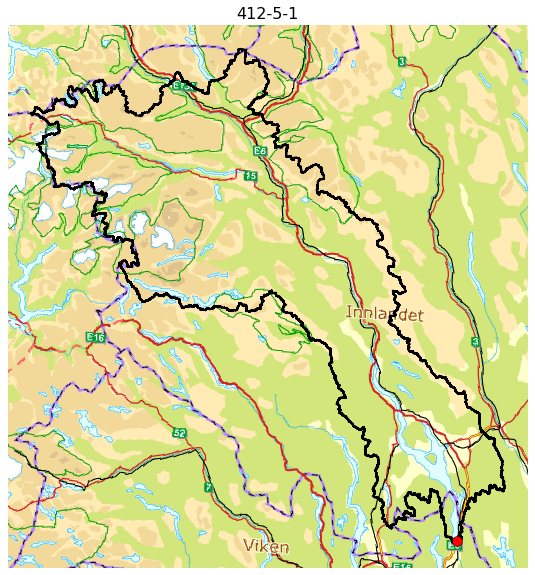

In [7]:
stn_code = "412-5-1"
nivapy.spatial.catchment_boundary_quickmap(stn_code, cat_gdf, stn_code)

## 5. Linking with other vector datasets

Other **vector** geospatial datasets available on the JupyterHub are listed [here](https://github.com/NIVANorge/niva_jupyter_hub/blob/master/postgis_db/postgis_db_dataset_summary.md). These can be combined with the catchment data in a variety of ways. The examples here are simple, but *not necessarily the most computationally efficient*.

For example, suppose we are interested in data for station `101-2-7` (Hokksjøen).

In [8]:
stn_code = "101-2-7"
cat_gdf.query("station_code == @stn_code")

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,"MULTIPOLYGON (((11.59333 59.01263, 11.59351 59..."


### 5.1. Check catchment boundary looks reasonable

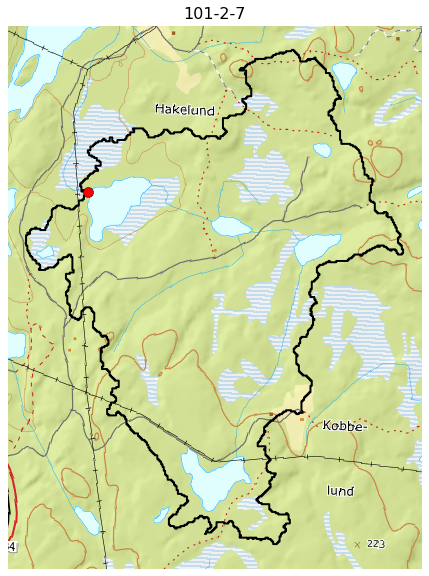

In [9]:
# First plot the catchment to check it looks reasonable
nivapy.spatial.catchment_boundary_quickmap(stn_code, cat_gdf, stn_code)

### 5.2. Get rivers and lakes for the same region (bounding box)

Remember to check your co-ordinate systems match before doing any spatial processing. The code below converts everything to WGS84-based UTM Zone 33N, which is a good general choice for Norwegian data.

In [10]:
# Get catchment of interest and reproject
clip_gdf = cat_gdf.query("station_code == @stn_code").to_crs("epsg:32633")

# Get the river network and reproject
riv_gdf = nivapy.da.read_postgis(
    "physical", "norway_nve_elvis_river_network_line", eng, clip=clip_gdf,
).to_crs("epsg:32633")

# Get lakes and reproject
lake_gdf = nivapy.da.read_postgis(
    "physical", "norway_nve_innsjo_poly", eng, clip=clip_gdf,
).to_crs("epsg:32633")

Converting to the projection of target dataset (epsg:25833)


<AxesSubplot:>

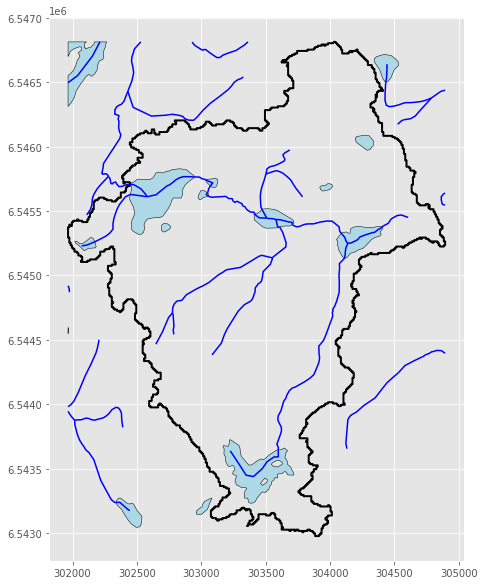

In [11]:
# Simple map
ax = lake_gdf.plot(facecolor="lightblue", edgecolor="k", figsize=(10, 10))
riv_gdf.plot(ax=ax, edgecolor="b")
clip_gdf.plot(ax=ax, facecolor="none", edgecolor="k", lw=2)

Comparing this to the "quickmap" above shows that this is the same data as used on Kartverkete's N50 map series, except we now have the actual geospatial data to work with, not just the base image from the Kartverket WMS.

### 5.3. Land cover

We can extract land cover information in the same way. The example below uses Corine 2018, but a [range of other datasets](https://github.com/NIVANorge/niva_jupyter_hub/blob/master/postgis_db/postgis_db_dataset_summary.md) are also available.

<AxesSubplot:>

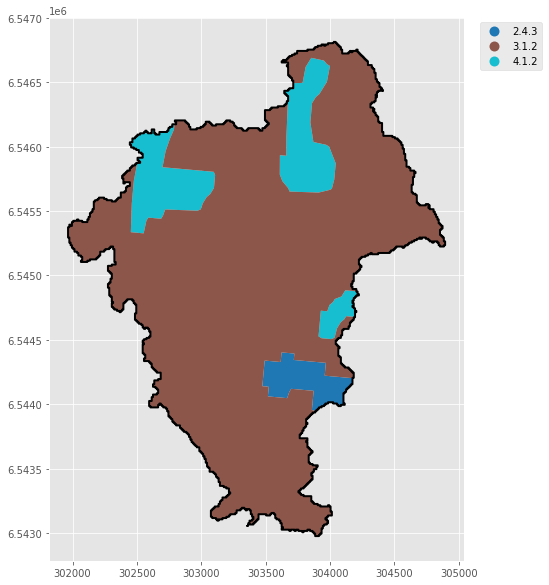

In [12]:
# Extract CORINE-2018 land cover, clipping to the specified catchment
lu_gdf = nivapy.da.read_postgis(
    "physical", "norway_nibio_corine_2018_poly", eng, clip=clip_gdf,
).to_crs("epsg:32633")

# Intersect with catchment
lu_gdf = gpd.overlay(lu_gdf, clip_gdf, how="intersection")

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

lu_gdf.plot(
    column="klasse", legend=True, legend_kwds={"bbox_to_anchor": (1.2, 1)}, ax=ax,
)

clip_gdf.plot(edgecolor="k", facecolor="none", ax=ax, lw=2)

In [13]:
# Summarise land use statistics
lu_gdf = lu_gdf.dissolve(["klasse"])[["norsk", "english", "geometry"]]
lu_gdf["area_km2"] = lu_gdf["geometry"].area / 1e6
lu_gdf

,norsk,english,geometry,area_km2
klasse,,,,
2.4.3,Spredt jordbruksareal,"Land principally occupied by agriculture, with...","POLYGON ((303719.087 6544343.554, 303968.143 6...",0.170786
3.1.2,Barskog,Coniferous forest,"MULTIPOLYGON (((304405.000 6546445.000, 304415...",4.709102
4.1.2,Myr,Peat bogs,"MULTIPOLYGON (((304195.000 6544677.307, 304126...",0.621611


## 6. Linking with raster datasets

To summarise raster datasets based on catchment polygons we can use the [`rasterio`](https://rasterio.readthedocs.io/en/latest/index.html) and [`rasterstats`](https://pythonhosted.org/rasterstats/index.html) packages.

**Important note:** You *must* make sure the raster and vector datasets have the same co-ordinate system (datum, projection etc.). `rasterstats` performs calculations on a Cartesian grid, which assumes the spatial reference information in both datasets is the same.

The example below calculates summary elevation statistics for each catchment in the 1000 Lakes dataset based on Kartverket's 50 m resolution DEM.

In [14]:
# Check CRS of DEM
dem_path = r"/home/jovyan/shared/01_datasets/spatial/norway_kartverket_50m_dem.tif"
with rasterio.open(dem_path) as src:
    print(src.crs)

PROJCS["ETRS89 / UTM zone 33N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


The DEM uses ETRS89-based UTM zone 33N (EPSG 25833). This is very similar - but not identical - to WGS84-based UTM Zone 33N (EPSG 32633), which we have used above for the catchment data. The easiest way to proceed is therefore to **reproject the catchments to EPSG 25833** to match the DEM.

The code below calculates a variety of summary statistics (in this case "min", "max", "median" and "mean" elevation) for just a single catchment.

In [15]:
# Zonal stats for a single catchment
stats = zonal_stats(
    clip_gdf["geom"].to_crs("epsg:25833"), dem_path, stats=["min", "max", "median", "mean"]
)
stats

[{'min': 147.0, 'max': 230.0, 'mean': 178.85070550751024, 'median': 174.0}]

It is also possible to process all 1001 catchments in a single operation.

In [16]:
# Zonal stats for all catchments
stats = zonal_stats(
    cat_gdf["geom"].to_crs("epsg:25833"), dem_path, stats=["min", "max", "median", "mean"]
)

# Convert results to dataframe and join station names etc.
stats = pd.DataFrame(stats)
stats = pd.concat(
    [cat_gdf[["station_id", "station_code", "station_name"]], stats], axis="columns"
)

stats.head()

,station_id,station_code,station_name,min,max,mean,median
0,259,221-1-2,Langtjern,274.0,292.0,281.352601,282.0
1,260,101-2-7,Hokksjøen,147.0,230.0,178.850706,174.0
2,261,402-2-13,Sætertjern,251.0,344.0,287.918530,281.0
3,262,419-1-25,Mjøgsjøen,489.0,516.0,500.643032,500.0
4,263,425-2-2,Kottern,479.0,629.0,516.534038,511.0
